# Project: Arabic poetry classification
# Abstract
### An attempt is made to classify  Arabic poets. The dataset consist of 58021 poets that will be classified into five different groups (العصر العباسي,العصر الأندلسي , العصر الإسلامي, العصر الجاهلي, العصر الحديث). In this project, I will understand the data and try to provide a solution for how to classify Arabic poets.

#  0. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import nltk
from nltk.stem.isri import ISRIStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
from tqdm import tqdm as tq
import csv

import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics  import classification_report, accuracy_score, f1_score,precision_score,recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn import svm

from keras.callbacks import EarlyStopping

%matplotlib inline

Using TensorFlow backend.


# 1. Load the dataset.

In [2]:
fields = ['poem_id', 'poem_style','poem_text','poem_title','poet_cat','poet_id','poet_name']

poem = pd.read_csv('Arabic Poetry Dataset/all_poems_58K.csv',usecols=fields,encoding='utf-8') 
poem.head()

,poem_id,poem_style,poem_text,poem_title,poet_cat,poet_id,poet_name
0,21,فصحى,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,أنشودة المطر,العراق,2,بدر شاكر السياب
1,65546,فصحى,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,أقداح و أحلام,العراق,2,بدر شاكر السياب
2,65561,فصحى,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...,هوى واحد !,العراق,2,بدر شاكر السياب
3,65554,فصحى,اساطير من حشرجات الزمان نسيج اليد البالية رواه...,أساطير,العراق,2,بدر شاكر السياب
4,65550,فصحى,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...,اللقاء الأخير,العراق,2,بدر شاكر السياب


# 2. EDA.

### print number of rows and columns

In [3]:
poem.shape

(58021, 7)

### Print the full summary

In [4]:
poem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58021 entries, 0 to 58020
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   poem_id     58021 non-null  int64 
 1   poem_style  58021 non-null  object
 2   poem_text   58020 non-null  object
 3   poem_title  58021 non-null  object
 4   poet_cat    58021 non-null  object
 5   poet_id     58021 non-null  int64 
 6   poet_name   58021 non-null  object
dtypes: int64(2), object(5)
memory usage: 3.1+ MB


It seems that there is a null value in poem_text

In [5]:
poem.isna().sum()

poem_id       0
poem_style    0
poem_text     1
poem_title    0
poet_cat      0
poet_id       0
poet_name     0
dtype: int64

#### Returning the index of the null value

In [6]:
poem[poem['poem_text'].isnull()].index.tolist()

[2454]

#### Displaying the null value

In [7]:
poem.iloc[2454]

poem_id            6200
poem_style         فصحى
poem_text           NaN
poem_title     الأشباح 
poet_cat        البحرين
poet_id              68
poet_name     قاسم حداد
Name: 2454, dtype: object

#### Let's drop the null value

In [8]:
poem = poem.dropna(axis=0, subset=['poem_text'])

In [9]:
poem[poem['poem_text'].isnull()].index.tolist()

[]

#### View the unique categories

In [10]:
poem.poet_cat.unique()

array(['العراق', 'سوريا', 'مصر', 'تونس', 'السعودية', 'لبنان', 'فلسطين',
       'اليمن', 'العصر الجاهلي', 'العصر الأندلسي', 'السودان', 'البحرين',
       'العصر الإسلامي', 'العصر العباسي', 'ليبيا', 'عمان', 'المغرب',
       'الجزائر', 'الإمارات', 'الأردن', 'الكويت', 'قطر', 'موريتانيا',
       'شعراء العراق والشام', 'أفغانستان', 'إيران'], dtype=object)

### It seem that we have (العصر العباسي,العصر الأندلسي , العصر الإسلامي, العصر الجاهلي, وأسماء دول  ), the country names will be converted into العصر الحديث.

### If there is any duplicate poem, remove it.

In [11]:
poem.drop_duplicates(subset='poem_text', inplace=True)

In [12]:
poem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57693 entries, 0 to 58020
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   poem_id     57693 non-null  int64 
 1   poem_style  57693 non-null  object
 2   poem_text   57693 non-null  object
 3   poem_title  57693 non-null  object
 4   poet_cat    57693 non-null  object
 5   poet_id     57693 non-null  int64 
 6   poet_name   57693 non-null  object
dtypes: int64(2), object(5)
memory usage: 3.5+ MB


##### The poem number reduced from 58020 to 57693 after removing the dublicated poems

### Now, let's view one poem, to check for any special character

In [13]:
poem.poem_text.iloc[1]

' انا لا ازال و في يدي قدحي ياليل اين تفرق الشرب ما زلت اشربها و اشربها حتي ترنح افقك الرحب الشرق عفر بالضباب فما يبدو فاين سناك يا غرب ما لنجوم غرقن من سام في ضوءهن و كادت الشهب انا لا ازال و في يدي قدحي ياليل اين تفرق الشرب ****** الحان بالشهوات مصطخب حتي يكاد بهن ينهار و كان مصاحبيه من ضرج كفان مدهما لي العار كفان بل ثغران قد صبغا بدم تدفق منه تيار كاسان ملءهما طلي عصرت من مهجتين رماهما الحب او مخلبان عليهما مزق حمراء تزعم انها قلب ****** الخمر جمعت الدهور , ومافيهن بين جوانب الحان ياويحها اسكرت ام سكرتام نحن في السكرات سيان رمت العوالم والدهور علي ثغري وفوق يدي واجفاني كفي تمد فما تناولني كاسا لعيني خمرها نهب واصافح الدنيا فياعجبا البعد لان واعرض القرب ****** يا ليل اين تطوف بي قدمي في اي منعرج من الظلم تلك السبيل اكاد اعرفها بالامس خاصر طيفها حلمي هي غمد خنجرك الرهيب و قد جردته و مسحت عنه دمي تلك السبيل علي جوانبها تمزق الخطوات او تكبو تثاءب الاجساد جاءعة فيها كما يتثاءب الذءب حسناء يلهب عريها ظماي فاكاد اشرب ذلك العريا و اكاد احطمه فتحطمني عينان جاءعتان كالدنيا غرست يد الحمي علي 

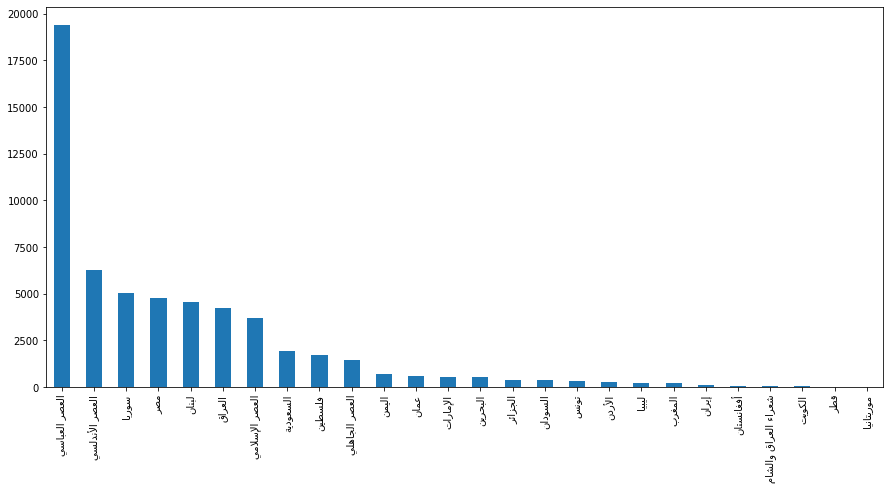

In [14]:
import arabic_reshaper
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
x = [ ]
for item in poem.poet_cat.values:
    x.append(get_display(arabic_reshaper.reshape(item)))
poem['Arabic_name'] = x
poem['Arabic_name'].value_counts().plot(kind='bar', figsize=(15,7))

# Data Preprocessing

### Let's remove any special character and numbers form the poems

In [15]:
arabic_punctuations = '''`÷×-؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
numbers = '،؛؟”0123456789“'

punctuations_list = arabic_punctuations + numbers
def removePunctuation(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

poem['cleaned_text'] = poem['poem_text'].apply(lambda x: removePunctuation(x))

In [16]:
poem.head()

,poem_id,poem_style,poem_text,poem_title,poet_cat,poet_id,poet_name,Arabic_name,cleaned_text
0,21,فصحى,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,أنشودة المطر,العراق,2,بدر شاكر السياب,ﻕﺍﺮﻌﻟﺍ,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...
1,65546,فصحى,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,أقداح و أحلام,العراق,2,بدر شاكر السياب,ﻕﺍﺮﻌﻟﺍ,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...
2,65561,فصحى,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...,هوى واحد !,العراق,2,بدر شاكر السياب,ﻕﺍﺮﻌﻟﺍ,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...
3,65554,فصحى,اساطير من حشرجات الزمان نسيج اليد البالية رواه...,أساطير,العراق,2,بدر شاكر السياب,ﻕﺍﺮﻌﻟﺍ,اساطير من حشرجات الزمان نسيج اليد البالية رواه...
4,65550,فصحى,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...,اللقاء الأخير,العراق,2,بدر شاكر السياب,ﻕﺍﺮﻌﻟﺍ,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...


# NLP Techniques.
### Now, it is time to perform tokenization (chopping a character into pieces)

In [17]:
poem["cleaned_text"] = poem["cleaned_text"].apply(nltk.word_tokenize)

In [18]:
poem.head()

,poem_id,poem_style,poem_text,poem_title,poet_cat,poet_id,poet_name,Arabic_name,cleaned_text
0,21,فصحى,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,أنشودة المطر,العراق,2,بدر شاكر السياب,ﻕﺍﺮﻌﻟﺍ,"[عيناك, غابتا, نخيل, ساعة, السحر, او, شرفتان, ..."
1,65546,فصحى,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,أقداح و أحلام,العراق,2,بدر شاكر السياب,ﻕﺍﺮﻌﻟﺍ,"[انا, لا, ازال, و, في, يدي, قدحي, ياليل, اين, ..."
2,65561,فصحى,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...,هوى واحد !,العراق,2,بدر شاكر السياب,ﻕﺍﺮﻌﻟﺍ,"[علي, مقلتيك, ارتشفت, النجوم, وعانقت, امالي, ا..."
3,65554,فصحى,اساطير من حشرجات الزمان نسيج اليد البالية رواه...,أساطير,العراق,2,بدر شاكر السياب,ﻕﺍﺮﻌﻟﺍ,"[اساطير, من, حشرجات, الزمان, نسيج, اليد, البال..."
4,65550,فصحى,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...,اللقاء الأخير,العراق,2,بدر شاكر السياب,ﻕﺍﺮﻌﻟﺍ,"[والتف, حولك, ساعداي, ومال, جيدك, في, اشتهاء, ..."


In [19]:
poem.shape

(57693, 9)

In [20]:
poem['cleaned_text']

0        [عيناك, غابتا, نخيل, ساعة, السحر, او, شرفتان, ...
1        [انا, لا, ازال, و, في, يدي, قدحي, ياليل, اين, ...
2        [علي, مقلتيك, ارتشفت, النجوم, وعانقت, امالي, ا...
3        [اساطير, من, حشرجات, الزمان, نسيج, اليد, البال...
4        [والتف, حولك, ساعداي, ومال, جيدك, في, اشتهاء, ...
                               ...                        
58016    [لروح, صهيل, لا, تحويه, الاوقات, ذنبك, انك, تم...
58017    [اه, لو, اني, ابني, الشمس, بعيني, من, طين, هوا...
58018    [في, عينيك, يا, امي, لماذا, الدمع, منتظم, كعقد...
58019    [النوم, يوقظ, طرفي, الظامي, علي, لحن, تموج, من...
58020    [السلم, الذي, نزلت, فيه, لسماء, سلم, من, الجنا...
Name: cleaned_text, Length: 57693, dtype: object

### Next step is to remove Arabic stop words

In [22]:
stop = stopwords.words('arabic')
poem['cleaned_text'] = poem['cleaned_text'].apply(lambda x: [word for word in tq(x) if word not in stop])

clear_output() #Clear the output

### Last step, (Stemming) bring the words back to their root

In [23]:
ISRIS_st = ISRIStemmer()
poem['cleaned_text'] = poem['cleaned_text'].apply(lambda x: [ISRIS_st.stem(word) for word in tq(x)])

clear_output()

In [ ]:
شسشيسشيشسي

### This step is to save the tokenized and stemmed data, so later it can be read as a list to feed it to TfidfVectorizer, this will help in skipping the above steps so I can run the first cell and skip the rest until this step to save the time of preprocessing.

In [24]:
poem.to_csv('token_stem.csv', encoding='utf-8')

In [ ]:
poem = pd.read_csv('token_stem.csv') #token_stem

In [ ]:
poem['category'] = poem['poet_cat']
poem.head()    

### Now create a list of moden and old categories, to group all country names into one category.
#### The categories are (العصر العباسي,العصر الأندلسي , العصر الإسلامي, العصر الجاهلي, وأسماء دول), أسماء الدول will be converted into العصر الحديث

In [ ]:
modern= ['سوريا','مصر','لبنان','العراق','السعودية','فلسطين','اليمن','عمان'
         ,'الإمارات','البحرين','الجزائر','السودان','تونس','الأردن','ليبيا',
        'المغرب','إيران','أفغانستان','شعراء العراق والشام','الكويت','قطر','موريتانيا']

In [ ]:
poem['category'] = poem['category'].replace(modern, 'العصر الحديث')

In [ ]:
poem['category']
poem['category'].value_counts()

In [ ]:
x = [ ]
for item in poem.category.values:
    x.append(get_display(arabic_reshaper.reshape(item)))
poem['Arabic_name'] = x
poem['Arabic_name'].value_counts().plot(kind='bar', figsize=(15,7))

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(poem['category'])
encoded_lable = encoder.transform(poem['category'])
poem['classes']=encoded_lable

The most Frequent category is العصر الحديث with 26848 poem

### Visualize the count of categories

# 5. split the data into training and testingn (consider only poem and category).

In [ ]:
x_train, y_test, x_label, y_label = train_test_split(poem['cleaned_text'], poem['classes'], test_size=0.25, random_state=42)

In [ ]:
print(x_train.shape, y_test.shape, x_label.shape, y_label.shape)

# 6. Now create a matrix of TF-IDF features. Set the max_features to 1000, if not then 6032543 features will be considerd, to reduce computational cost set it to 1000.

In [ ]:
def tfidf(poem):    
    tf = TfidfVectorizer(max_features=10000,ngram_range=(1, 2),min_df=0)

    tfidf_matrix = tf.fit_transform(poem['cleaned_text'])

    trainTfidf = tf.transform(x_train)
    testtfidf = tf.transform(y_test)
    return trainTfidf,testtfidf

In [ ]:
trainTfidf,testtfidf = tfidf(poem)

# 7. Trying different models to see which one is better.

### First one to use is Logistic Regression.

In [ ]:
logClassifier = LogisticRegression(solver='sag', C=10,penalty='l2')
logClassifier.fit(trainTfidf, x_label)
logPredictions = logClassifier.predict(testtfidf)

print("accuracy :",metrics.accuracy_score(y_label,logPredictions))
print("macro f1 score :",metrics.f1_score(y_label, logPredictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_label, logPredictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_label,logPredictions))
print("Precision recall report :\n",metrics.classification_report(y_label, logPredictions))

In [ ]:
X = poem[['cleaned_text']]
Y = poem['classes']

print(X.shape)
print(Y.shape)

In [ ]:
# RandomOverSampler to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0) 
X_res,Y_res=ros.fit_resample(X,Y)

In [ ]:
# x_train.array.reshape(-1, 1)
from collections import Counter
print(sorted(Counter(Y_res).items()))

In [ ]:
X1=pd.DataFrame(X_res,columns=['cleaned_text'])

In [ ]:
Y1=pd.DataFrame(Y_res,columns=['classes'])

In [ ]:
Final_data=pd.concat([X1,Y1],axis=1)
Final_data.head()

In [ ]:
x_train, y_test, x_label, y_label = train_test_split(Final_data['cleaned_text'], Final_data['classes'], test_size=0.25, random_state=42)

In [ ]:
print(x_train.shape, y_test.shape, x_label.shape, y_label.shape)

In [ ]:
trainTfidf,testtfidf = tfidf(Final_data)

In [ ]:
logClassifier = LogisticRegression(solver='sag', C=10,penalty='l2')
logClassifier.fit(trainTfidf, x_label)
logPredictions = logClassifier.predict(testtfidf)

print("accuracy :",metrics.accuracy_score(y_label,logPredictions))
print("macro f1 score :",metrics.f1_score(y_label, logPredictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_label, logPredictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_label,logPredictions))
print("Precision recall report :\n",metrics.classification_report(y_label, logPredictions))

#### lets use Kfold cross validation on Logistic Regression to see if there is any improvement.

In [ ]:
logKfold = cross_val_score(logClassifier, trainTfidf, x_label, cv=10)
print(logKfold)

After using Kfold the results are almost the same, no improvements.

### Stochastic Gradient Descent Classifier been successfully applied to large-scale of machine learning problems, often encountered in text classification and NLP, so I decided to use it.

In [ ]:
classifier = SGDClassifier(loss='log', alpha=0.00001, penalty='l1', verbose=0)
classifier.fit(trainTfidf, x_label)
predictions = classifier.predict(testtfidf)

print("accuracy :",metrics.accuracy_score(y_label,predictions))
print("macro f1 score :",metrics.f1_score(y_label, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_label, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_label,predictions))
print("Precision recall report :\n",metrics.classification_report(y_label, predictions))

SGD classifier perfomded almosl as good as logistic regression

### Another classifier to compare with is Gaussian Naive Bayes.

In [ ]:
# nbClassifier = GaussianNB()
# nbscore=nbClassifier.fit(trainTfidf.toarray(), x_label)
# nbPredictions = nbClassifier.predict(testtfidf.toarray())

# print("accuracy :",metrics.accuracy_score(y_label,nbPredictions))
# print("macro f1 score :",metrics.f1_score(y_label, nbPredictions, average = 'macro'))
# print("micro f1 scoore :",metrics.f1_score(y_label, nbPredictions, average = 'micro'))
# print("hamming loss :",metrics.hamming_loss(y_label,nbPredictions))
# print("Precision recall report :\n",metrics.classification_report(y_label, nbPredictions))

Gaussian naive bayes did not perfom well as compared to the previos models

### Last one to compare with is K nearest neighbors, let's choose different values of K to see what fits better.

In [ ]:
# k = 5
# BOW_Train_Accuracy = []
# BOW_CV_Accuracy = []

# model = KNeighborsClassifier(n_neighbors=k)
# model.fit(trainTfidf,x_label)
# BOW_Train_Accuracy.append(model.score(trainTfidf,x_label))
# BOW_CV_Accuracy.append(model.score(testtfidf,y_label))

# knn=model.predict(testtfidf)
# print("accuracy :",metrics.accuracy_score(y_label,knn))
# print("macro f1 score :",metrics.f1_score(y_label, knn, average = 'macro'))
# print("micro f1 scoore :",metrics.f1_score(y_label, knn, average = 'micro'))
# print("hamming loss :",metrics.hamming_loss(y_label,knn))
# print("Precision recall report :\n",metrics.classification_report(y_label, knn))

In [ ]:
poem.head()

It seems that 20 K is better for KNN, however the accuracy is not that good.

# 8.Conclusion.
### In this project, a classification model was built to classify Arabic poets using different models. As we see above, logostic regression and SGD performed better than the others, to get a better accuracy it is possible to change hyperparameter values and try different models, this can result even in choosing a better model.


In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
n_most_common_words = 10000
max_len = 150
def preprocess(poem):
    tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(poem['poem_text'].values)
    sequences = tokenizer.texts_to_sequences(poem['poem_text'].values)
    word_index = tokenizer.word_index
    print('There are %s unique tokens.' % len(word_index))

    X = pad_sequences(sequences, maxlen=max_len)
    return X

In [ ]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(poem['classes'], num_classes=5)
print(labels[:10])

In [ ]:
X = preprocess(poem)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

In [ ]:
epochs = 10
emb_dim = 150
batch_size = 128

In [ ]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(32, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(16))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

In [ ]:
acc = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc[0],acc[1]))

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'o-', label='Training acc')
plt.plot(epochs, val_acc, '--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'o-', label='Training loss')
plt.plot(epochs, val_loss, '--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()